# Analysis of the growth rates measured on 2019-05-11

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [1]:
import os
import itertools

# Our numerical workhorses
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import sys
sys.path.insert(0, '../../../../')
import evo_utils

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Set PBoC plotting format
evo_utils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

## Experiment setup

For this particular experiment we grew the following strains:

| Plasmid | Genotype | Host Strain | Shorthand |
| :------ | :------- | ----------: | --------: |
| `pZS4*5-mCherry`| `galK<>25O2+11-sacB-cmR-YFP` |  HG105 |`O2 R0` |
| `pZS4*5-mCherry`| `galK<>25O2+11-sacB-cmR-YFP` |  HG104 |`O2 R22` |
| `pZS4*5-mCherry`| `galK<>25O2+11-sacB-cmR-YFP`, `ybcN<>4*5-RBS1027-lacI` |  HG105 |`O2 R260` |
| `pZS4*5-mCherry`| `galK<>25O2+11-sacB-cmR-YFP`, , `ybcN<>4*5-RBS1L-lacI` |  HG105 |`O2 R1740` |
| `pZS4*5-mCherry`| `galK<>25O3+11-sacB-cmR-YFP` |  HG105 |`O3 R0` |
| `pZS4*5-mCherry`| `galK<>25O3+11-sacB-cmR-YFP` |  HG104 |`O3 R22` |
| `pZS4*5-mCherry`| `galK<>25O3+11-sacB-cmR-YFP`, `ybcN<>4*5-RBS1027-lacI` |  HG105 |`O3 R260` |
| `pZS4*5-mCherry`| `galK<>25O3+11-sacB-cmR-YFP`, , `ybcN<>4*5-RBS1L-lacI` |  HG105 |`O3 R1740` |

These were grew on a 96-well plate in the plate reader with and without 5µg/mL chloramphenicol selection.

The objective of this notebook is to analyze the difference in growth rate as a function of the operator and the repressor copy number between the cultures with and without selection.

Let's begin by importing the growth rates as inferred with the Gaussian process method.

In [3]:
df_gp = pd.read_csv('./output/20190503_r1_gp_per_well.csv', index_col=0)
df_gp.head()

,OD600,OD_sub,blank_val,date,doubling_time,doubling_time_std,growth_rate,growth_rate_std,logOD_fit,logOD_fit_std,...,misc,operator,repressor,run_number,selection,strain,temp_C,time_min,volume_marker,well
0,0.078,-0.000167,0.078167,20190503,1706.223766,1136.106473,0.000406,0.000271,-2.554131,0.003370,...,ref,O2,0.0,1,None,O2_R0_mCh,37.0,5.466667,mCh,B10
1,0.078,-0.000667,0.078667,20190503,2031.435103,1195.894299,0.000341,0.000201,-2.551884,0.002372,...,ref,O2,0.0,1,None,O2_R0_mCh,37.0,11.466667,mCh,B10
2,0.078,0.000000,0.078000,20190503,2561.672125,1376.869045,0.000271,0.000145,-2.550047,0.001887,...,ref,O2,0.0,1,None,O2_R0_mCh,37.0,17.466667,mCh,B10
3,0.078,-0.000333,0.078333,20190503,3491.084373,1826.221758,0.000199,0.000104,-2.548640,0.001744,...,ref,O2,0.0,1,None,O2_R0_mCh,37.1,23.466667,mCh,B10
4,0.078,-0.000167,0.078167,20190503,5380.970749,3175.445567,0.000129,0.000076,-2.547660,0.001732,...,ref,O2,0.0,1,None,O2_R0_mCh,37.0,29.466667,mCh,B10


Let's quickly take a look at all the inferred growth rates from each well. This is just a rough look at the kind of data we are looking at.

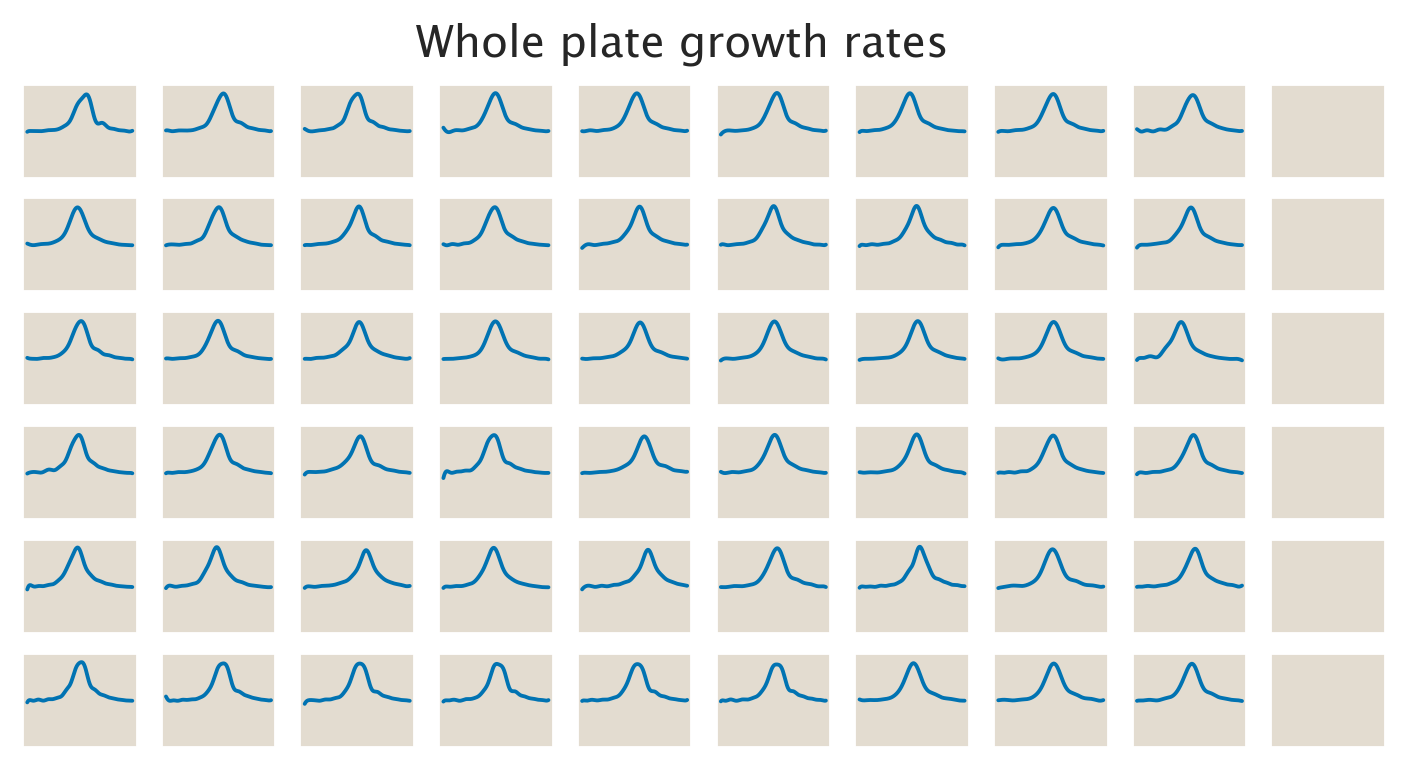

In [5]:
# group derivatives
df_gp_group = df_gp.groupby(['well', 'strain'])
# find number of rows and columns from layout
layout = pd.read_excel(f'./20190503_plate_layout.xlsx', sheet_name='well',
                             header=None).values
layout_shape = layout.shape

# Initlaize plot
fig, ax = plt.subplots(layout_shape[0], layout_shape[1], figsize=(8, 4),
                       sharex=True, sharey=True)

# Loop through each well
for group, df in df_gp_group:
    # Find corresponding row and column of plot
    r, c = [int(x) for x in np.where(layout == group[0])]
    # Set plot axis
    ax[r][c].set_ylim([-0.01, 0.01])
    # Plot growth rate
    ax[r][c].plot(df.time_min, df.growth_rate)
    # increase counter

# Remove axis from all plots
ax = ax.ravel() # ravel list of axis

# Loop through axis
for a in ax:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)

_ = fig.suptitle(f'Whole plate growth rates', y=0.95)

So we can see that except for one noisy measurement all of the growth rate inferences seem to have a single peak. Let's take a single example to work with and explore further. We'll choose well B2.

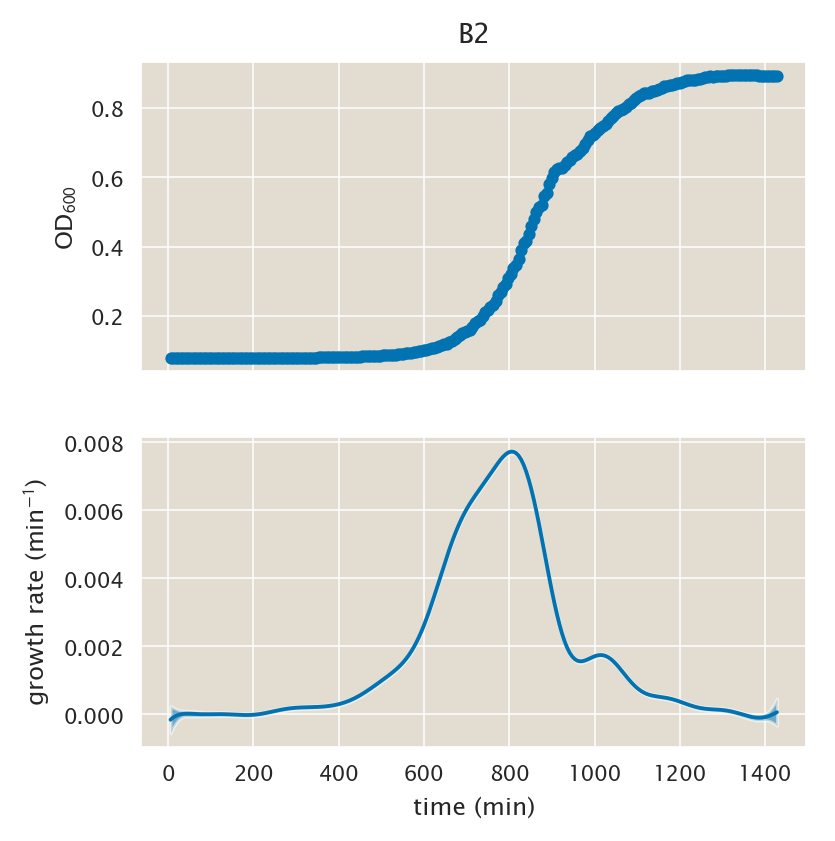

In [6]:
# Define well
well = 'B2'

# Initialize figure to plot growth curve and inferred growth rate
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
# Extract curve data
df_well = df_gp[df_gp.well == well]
time = df_well.time_min
growth_data = df_well.OD600
rate_data = df_well.growth_rate
rate_std = df_well.growth_rate_std

# Plot plate reade data
ax[0].plot(time, growth_data, lw=0,
           marker='.')
# Plot growth rate with credible region
ax[1].plot(time, rate_data)
ax[1].fill_between(time,
                   rate_data + rate_std,
                   rate_data - rate_std,
                   alpha=0.5)
# Label plot
ax[0].set_title(well)
ax[0].set_ylabel(r'OD$_{600}$')
ax[1].set_ylabel(r'growth rate (min$^{-1}$)')
ax[1].set_xlabel('time (min)')
plt.tight_layout()

We can obviously find the maximum growth rate very easily just by finding the maximum value among the list. but for a more robust method we'll use `scipy`'s `signal` module.

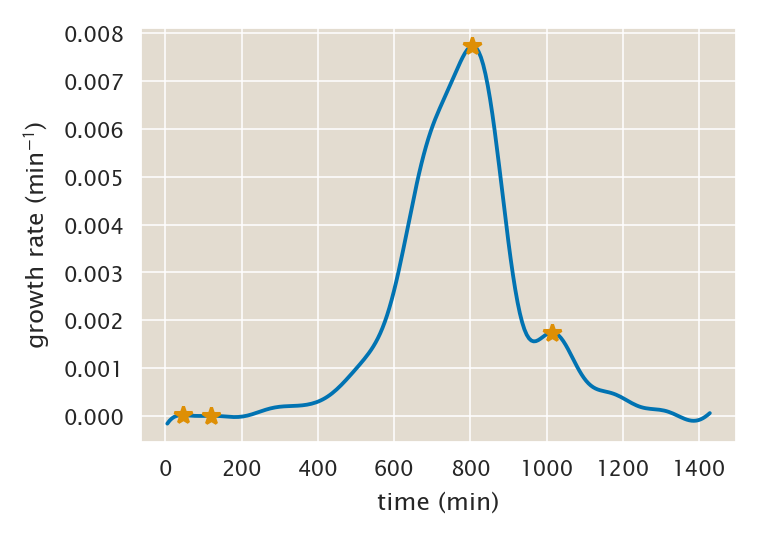

In [7]:
# Find peaks in signal
peaks = scipy.signal.find_peaks(df_well.growth_rate)[0]

# Plot growth rate with highlighted peaks
plt.plot(df_well.time_min, df_well.growth_rate)
plt.plot(df_well.time_min.values[peaks], 
         df_well.growth_rate.values[peaks],
         marker='*', lw=0)
plt.ylabel(r'growth rate (min$^{-1}$)')
_ = plt.xlabel('time (min)')

Let's extract the maximum growth rate for each of the wells.

In [8]:
# Initialize data frame to save maximum growth rate
df_max = pd.DataFrame(columns=df_gp.columns)

# Group data by well
df_group = df_gp.groupby('well')

# Loop through wells
for well, data in df_group:
    # Check that it is not the noisy well
    if well != 'B6':
        # Find peaks
        peaks = scipy.signal.find_peaks(data.growth_rate)[0]
        # Find the growth rate that gives the largest peak
        max_idx = peaks[np.argmax(data.growth_rate.values[peaks])]
        # Get data for maximum peak
        max_data = data.iloc[max_idx]
        # Append to data frame
        df_max = df_max.append(max_data)

The data set includes a bunch of wells that were in the outer rim of the plate that we will ignore. They are defined by having a value in the column `misc` equal to `ref`.

In [9]:
df_max = df_max[df_max.misc != 'ref']
df_max.shape

(32, 21)

As a first overview let's look at these growth rates for the strains with and without selection.

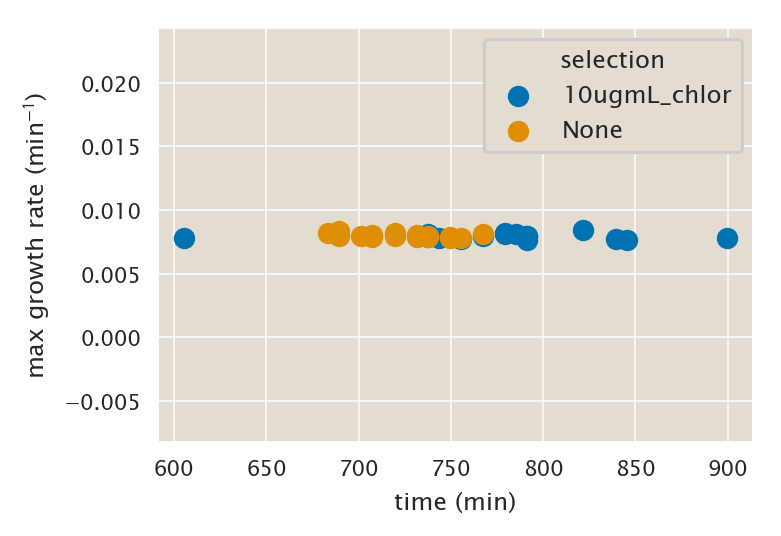

In [10]:
# group by selection
df_group = df_max.groupby('selection')

# Loop through groups
for group, data in df_group:
    # Plot max growth rate vs when it happened
    plt.scatter(data.time_min, data.growth_rate, label=group)
    
# Label plot
plt.xlabel('time (min)')
plt.ylabel('max growth rate (min$^{-1}$)')
plt.legend(title='selection')

That is surprising. It seems that there is no correlation between the maximum growth rate in the presence and absence of selection. There is only a time shift between when this maximum is reached. But even then we can see that the strains grown without selection reach the peak within a range of 300 min form each other.

Let's look at another correlation. For this we will plot the time to reach the maximum growth rate as a function of the theoretical fold-change for each strain. This fold-change is related to the relative expression level.

(0.001, 1.2986231662845926)

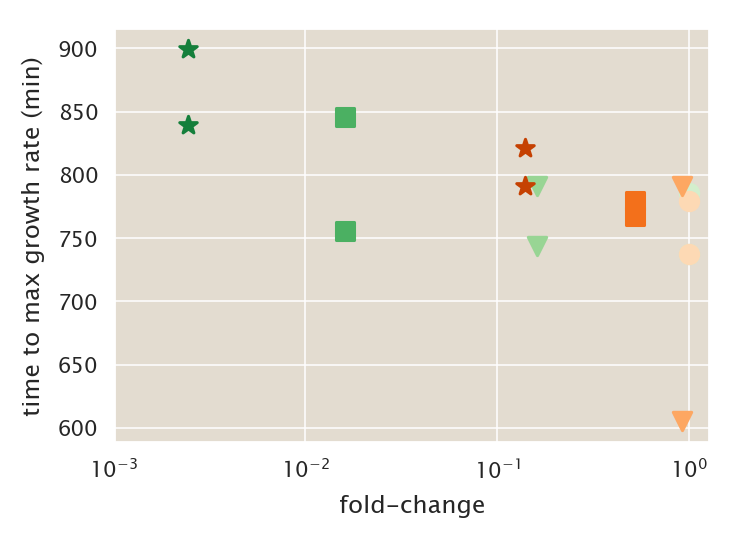

In [14]:
# Define binding energies for operators
eRA_dict = {'O2': -13.9, 'O3': -9.7}

# group by selection
df_group = df_max[df_max.selection == '10ugmL_chlor'].groupby(['operator',                                                                     'repressor'])
# List groups
groups = [group for group, data in df_group]


# Define colors
colors = sns.color_palette('Greens', 
                           n_colors=len(df_max.repressor.unique()))
colors = colors + sns.color_palette('Oranges', 
                             n_colors=len(df_max.repressor.unique()))

# Generate color dictionary
col_dict = dict(zip(groups, colors))

# Define markers for repressor copy number
rep_dict = dict(zip(df_max.repressor.unique(), 
                    ['o', 'v', 's', '*']))

# Loop through groups
for group, data in df_group:
    # Extract strain information
    eRA = eRA_dict[data.operator.unique()[0]]
    rep = data.repressor.unique()[0]
    # Compute theoretical fold-change
    fc = evo_utils.model.fold_change(0, rep, eRA)
    # Plot max growth rate vs fold-change
    plt.scatter([fc] * len(data), data.time_min, label=group,
                color=col_dict[group], 
                marker=rep_dict[group[-1]])
    
# Label plot
plt.xlabel('fold-change')
plt.ylabel('time to max growth rate (min)')
# Change axis
plt.xscale('log')
plt.xlim(left=1E-3)

There are several features to highlight here:
1. First of all the data is not perfect. For exmaple the most right orange points (O3 R0) have very very different times.
2. There might be a trend. The rank order of the values makes sense.